# ComSeg on large scale data with SOPA / SpatialData
### (Work in progress)
To ease the application of ComSeg on large datasets, ComSeg can be used with SOPA: https://gustaveroussy.github.io/sopa/  
Sopa is build on top of Spatial data

The following example is a modified version of the official SOPA tutorial : 
https://gustaveroussy.github.io/sopa/tutorials/api_usage/

In [22]:
import pandas as pd
import sopa.segmentation
import sopa.io
from matplotlib import pyplot as plt
from tqdm import tqdm
from sopa._sdata import to_intrinsic
import sopa
from spatialdata import SpatialData, read_zarr
from spatialdata.models import PointsModel
from pathlib import Path

### Example dataset

In [4]:
sdata = sopa.io.uniform()
image_key = "image"
points_key = "transcripts"
gene_column = "genes"

[INFO] (sopa.utils.data) Image of size ((4, 2048, 2048)) with 400 cells and 100 transcripts per cell


### Segmentation of nuclei with Cellpose 
The nucleus segmentation will be used as prior by ComSeg

In [ ]:
patches = sopa.segmentation.Patches2D(sdata, image_key, patch_width=1200, patch_overlap=50)
patches.write()
from sopa._sdata import get_spatial_image
print(get_spatial_image(sdata, image_key).c.values)
channels = ["DAPI"]
method = sopa.segmentation.methods.cellpose_patch(diameter=35, channels=channels, flow_threshold=2, cellprob_threshold=-6)
segmentation = sopa.segmentation.StainingSegmentation(sdata, method, channels, min_area=2500)


# The cellpose boundaries will be temporary saved here. You can choose a different path
cellpose_temp_dir = "tuto.zarr/.sopa_cache/cellpose"
segmentation.write_patches_cells(cellpose_temp_dir)

cells = sopa.segmentation.StainingSegmentation.read_patches_cells(cellpose_temp_dir)
cells = sopa.segmentation.shapes.solve_conflicts(cells)
shapes_key = "cellpose_boundaries" # name of the key given to the cells in sdata.shapes
sopa.segmentation.StainingSegmentation.add_shapes(sdata, cells, image_key, shapes_key)

### Compute the patches for ComSeg

In [9]:
image_key = "image"
points_key = "transcripts" # (ignore this for multiplex imaging)
gene_column = "genes" # (option
config_comseg = {}
baysor_temp_dir = "tuto.zarr/.sopa_cache/comseg"

patches = sopa.segmentation.Patches2D(sdata, points_key, patch_width=200, patch_overlap=50)
valid_indices = patches.patchify_transcripts(baysor_temp_dir, config=config_comseg, use_prior=True)

[INFO] (sopa.patches.patches) Writing sub-CSV for baysor


[########################################] | 100% Completed | 519.88 ms


[INFO] (sopa.patches.patches) Patches saved in directory tuto.zarr/.sopa_cache/comseg


### Compute centroid for ComSeg
This main difference with the original SOPA tutorial is the computation of the centroid needed for ComSeg

In [12]:
def add_centroids_to_sdata(sdata,
                           points_key="transcripts",
                           shapes_key='cellpose_boundaries', z_constant=None):
    centroid = sdata[shapes_key].geometry.centroid
    x_centroid = list(centroid.geometry.x)
    y_centroid = list(centroid.geometry.y)
    if z_constant is not None:
        z_centroid = [z_constant] * len(y_centroid)
        coords = pd.DataFrame({"x": x_centroid, "y": y_centroid, "z": z_centroid})

    else:
        if "z" in sdata[points_key].columns:
            z = list(sdata[points_key].z.unique().compute())
            assert len(z)==1, "3D point cloud with 2D segmentation, manually set z_constant"
            z_centroid = [z[0]] * len(y_centroid)
            coords = pd.DataFrame({"x": x_centroid, "y": y_centroid, "z": z_centroid})
        else:
            coords = pd.DataFrame({"x": x_centroid, "y": y_centroid})
    points = PointsModel.parse(coords)
    sdata['centroid'] = points
    sdata['centroid'] = to_intrinsic(sdata, sdata['centroid'], points_key)
    return sdata

sdata_centroid = SpatialData()
sdata_centroid['cellpose_boundaries'] = sdata['cellpose_boundaries']
sdata_centroid['transcripts'] = sdata['transcripts']
sdata_centroid = add_centroids_to_sdata(sdata_centroid,
                           points_key="transcripts",
                           shapes_key='cellpose_boundaries',
                               z_constant=1)


baysor_temp_dir = "tuto.zarr/.sopa_cache/comseg_centroid"
config_comseg ={}
points_key = "centroid"
patches = sopa.segmentation.Patches2D(sdata_centroid, points_key, patch_width=200, patch_overlap=50)
valid_indices = patches.patchify_transcripts(baysor_temp_dir, config=config_comseg, use_prior=True)

/home/tom/anaconda3/envs/sopa/lib/python3.10/site-packages/spatialdata/_core/_elements.py:102: UserWarning: Key `centroid` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
[INFO] (sopa.patches.patches) Writing sub-CSV for baysor


[########################################] | 100% Completed | 102.14 ms


[INFO] (sopa.patches.patches) Patches saved in directory tuto.zarr/.sopa_cache/comseg_centroid
[INFO] (sopa.patches.patches) Patch 0 has < 4000 transcripts. Baysor will not be run on it.
[INFO] (sopa.patches.patches) Patch 1 has < 4000 transcripts. Baysor will not be run on it.
[INFO] (sopa.patches.patches) Patch 2 has < 4000 transcripts. Baysor will not be run on it.
[INFO] (sopa.patches.patches) Patch 3 has < 4000 transcripts. Baysor will not be run on it.


### Run ComSeg on each patch

In [ ]:
import comseg
from comseg import dataset as ds
from comseg import dictionary
from comseg import model
import json

#### HYPERPARAMETER ####
MEAN_CELL_DIAMETER = 15  # in micrometer
MAX_CELL_RADIUS = 50  # in micrometer
#########################

path_transcript = "tuto.zarr/.sopa_cache/comseg"
path_centroid = "tuto.zarr/.sopa_cache/comseg_centroid"

for patch_index in tqdm(list(range(len(patches.ilocs)))):
    path_dataset_folder = Path(path_transcript) / str(patch_index)
    path_dataset_folder_centroid = Path(path_centroid) / str(patch_index)
    
    dataset = ds.ComSegDataset(
        path_dataset_folder=path_dataset_folder,
        dict_scale={"x": 1, 'y': 1, "z": 1},
        mean_cell_diameter = MEAN_CELL_DIAMETER,
        gene_column = "genes",
        )

    
    dico_proba_edge, count_matrix = dataset.compute_edge_weight(  # in micrometer
    images_subset=None,
    n_neighbors=40,
    sampling=True,
    sampling_size=10000
    )
    
    Comsegdict = dictionary.ComSegDict(
    dataset=dataset,
    mean_cell_diameter=MEAN_CELL_DIAMETER,
    community_detection="with_prior",
    prior_name="cell",
    )
    Comsegdict.run_all(max_cell_radius = MAX_CELL_RADIUS,
                        path_dataset_folder_centroid=path_dataset_folder_centroid,
                               file_extension=".csv")


                       
    anndata_comseg, json_dict = Comsegdict.anndata_from_comseg_result(
        return_polygon = True,
        alpha = 0.5,
        min_rna_per_cell = 5)
    anndata_comseg.write_loom(path_dataset_folder / 'segmentation_counts.loom')
    ## save the json_dict as json
    with open(path_dataset_folder / "segmentation_polygons.json", 'w') as f:
        json.dump(json_dict['transcripts'], f)

### Aggregate results

In [ ]:
from sopa.segmentation.baysor.resolve import resolve
resolve(sdata, path_transcript, gene_column, min_area=10)
shapes_key = "baysor_boundaries"
aggregator = sopa.segmentation.Aggregator(sdata, image_key=image_key, shapes_key=shapes_key)
aggregator.compute_table(gene_column=gene_column, average_intensities=True)
sdata

### Plot results

INFO     Value for parameter 'color' appears to be a color, using it as such.                                      


/home/tom/anaconda3/envs/sopa/lib/python3.10/site-packages/anndata/_core/aligned_df.py:67: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)
/home/tom/anaconda3/envs/sopa/lib/python3.10/site-packages/spatialdata/_core/_elements.py:102: UserWarning: Key `transcripts` already exists. Overwriting it.
  self._check_key(key, self.keys(), self._shared_keys)
/home/tom/anaconda3/envs/sopa/lib/python3.10/site-packages/spatialdata_plot/pl/render.py:327: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  _cax = ax.scatter(
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


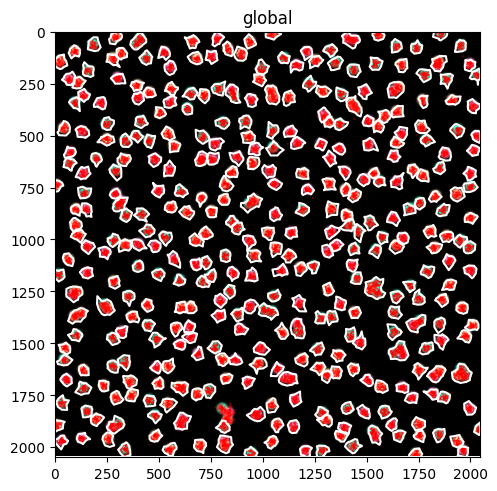

In [21]:
import spatialdata_plot
sdata.pl.render_points(size=0.01, color="r")\
    .pl.render_images()\
    .pl.render_shapes(shapes_key, outline=True, fill_alpha=0, outline_color="w")\
    .pl.show("global")
plt.show()